In [1]:
# install Yao/YaoPlots via 
#     using Pkg
#     Pkg.add("Yao")
#     Pkg.add("YaoPlots")

using Yao,YaoPlots,LinearAlgebra,Compose,Base.Filesystem

function svgplot(args...)
    file = tempname() * ".svg"
    draw(SVG(file, 24cm, 8cm),plot(args...))
    open(file) do f
        display("image/svg+xml", read(f, String))
    end
end;

#svgplot(args...) = plot(args...)

# Quantum Fourier Transform 

shift gate 

shift(θ) = [ 
    1, 0 ;
    0, exp(iθ) 
]             

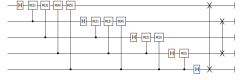

In [2]:
controlR(k) = control(k, 1=>label(shift(2π/2^k),"R($k)"))
qftblock(b) = chain(b, put(1=>H), chain(controlR(k) for k in 2:b))
qft(n) = chain(n, 
    chain(put(k:n => qftblock(n-k+1)) for k in 1:n),
    chain(swap(k,n-k+1) for k in Int.(1:(n/2)))
)

svgplot(qft(5))

# Phase Estimation

We define U(i) = U^2ⁱ as a composition of 2ⁱ gates U

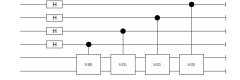

In [3]:
ublock(i,n,p,U) = chain(
    put(p-i=>H),
    control(p-i, p+1:p+n => label(matblock(U^(2^i)), "U($i)"))
)
ucircuit(n,p,U) = chain(n+p, ublock(i-1,n,p,U) for i in 1:p)
svgplot(ucircuit(2,4,rand_unitary(2^2)))

### Full Phase Estimation circuit

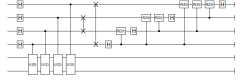

In [4]:
pecircuit(n,p,U) = chain(ucircuit(n,p,U), put(1:p => qft(p)'))
svgplot(pecircuit(2,4,rand_unitary(2^2)))

# Run the experiment

Construct a random n-qubit unitary matrix U with eigenvalues exp(2πik/2^p) for integers k and p. The precision p refers to the number of bits necessary to describe the phase

In [5]:
p = 4
n = 2

eigenvalues = [rand(0:2^p-1) for k in 1:2^n]

4-element Vector{Int64}:
 12
 12
 15
  6

In [6]:
V = rand_unitary(2^n)
U = V*Diagonal(map(k-> exp(2π*1im*k/2^p), eigenvalues))*V'

4×4 Matrix{ComplexF64}:
  0.068016-0.336556im     0.230579+0.306976im   …    0.76528-0.0898499im
  0.283872+0.410863im     0.359875-0.696835im       0.278199+0.186482im
 -0.332784-0.0572137im  -0.0840131-0.0185766im        0.2881+0.41899im
  0.151716-0.704043im     0.404658-0.257602im      -0.125647+0.140578im

In [7]:
ψ = zero_state(n+p) |> pecircuit(n,p,U)

ArrayReg{1, ComplexF64, Array...}
    active qubits: 6/6

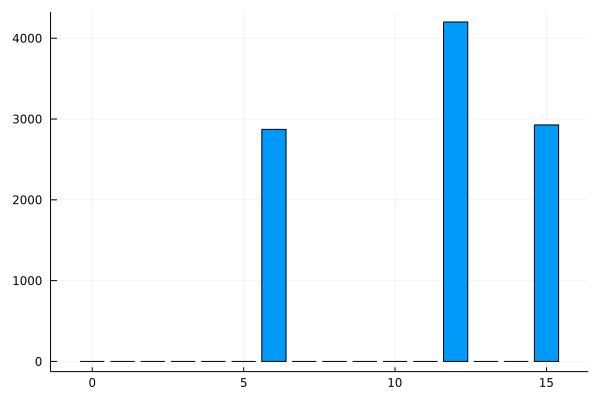

In [8]:
using Plots: bar

reversebits(x,p) = parse(Int,*(string.(digits(x; base=2,pad=p))...); base=2)

probs = measure(ψ,1:p,  nshots=10000)
counts = [(reversebits(i,p), count(==(i),Int.(probs))) for i=0:2^p-1]

bar(counts, legend=nothing)

In [9]:
sort(eigenvalues)

4-element Vector{Int64}:
  6
 12
 12
 15

The only possible outcomes are the eigenvalues of U